# Austin Bikeshare
Data comes from bigquery public datasets.

My aim is finding patterns among people with a specific type of subscription.
My first try of using maps with python. 

python = 3.9 for merging dict by | operator


In [2]:
#own settings of jupyer
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

importing libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
import numpy as np
from sklearn import preprocessing

import ipywidgets
from ipyleaflet import Map, Marker, CircleMarker

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = 'bike_share_austin')

In [4]:
#cell for function used here
def make_cordinates(address):
    location = geolocator.geocode(str(address) + ' Austin')
    if location is None:
        return 0,0
    return location.latitude, location.longitude

def rgb_to_hex(red, green, blue):
    """Return color as #rrggbb for the given color values."""
    return '#%02x%02x%02x' % (red, green, blue)

def draw_map(stations):
    #preparing map visualisation
    center = (30.2672, -97.7431)#austion cordinates from google
    m = Map(center=center, zoom = 11)
    for i in range(len(stations)):
        address = stations.latitude.iloc[i], stations.longitude.iloc[i]
        if stations.frequency.iloc[i] == 0:
            rgb_color = (215,215,215)

        else:
            rgb_color = (0,255-int(255*stations.normalized_freq.iloc[i]),255)
        hex_color = rgb_to_hex(*rgb_color)
        circle_marker = CircleMarker(location = address, radius = 2, color = hex_color)
        m.add_layer(circle_marker)
    return m
    

# Data
I have decided to create my own ids for stations (smaller numbers) as I don't know if there is any pattern in naming. I hope it will help in visualizing data

In [5]:
trips = pd.read_csv('austin_bikeshare_trips.csv')
trips_colnames = list(trips.columns)





In [6]:
stations = pd.read_csv('austin_bikeshare_stations.csv')
stations_colnames = list(stations.columns)
stations['adress'] = stations.address.astype('str')
#unused_stations = stations.sort_values(by = 'station_id', ascending = False).head(len(all_ids) - len(ids)).reset_index(drop = True)
#used_stations = pd.concat([stations, unused_stations]).drop_duplicates(keep = False)
stations[['latitude','longitude']] = stations.address.apply(make_cordinates).apply(pd.Series)

#save stations with cordinates as file because func needs a lot of time for loading


In [7]:
#Finding unconsistent data in end_station_id column  and cleaning end_station_id
trips_end_nan = trips[trips.end_station_id.isnull()]
trips_end_str = trips[trips['end_station_id'].str.contains('^[a-zA-Z]+$')==True]
trips_wo_end = pd.concat([trips_end_nan,trips_end_str])
trips = pd.concat([trips, trips_wo_end]).drop_duplicates(keep = False)
trips = trips.astype({'end_station_id' : int})
trips = trips.reset_index(drop = True)



In [ ]:
#create function to delete outliners in duration_minutes(currently max == 300 hours)
#maybe cut it to 24h, and give mean for deleted rows?




In [8]:

old_ids = pd.concat([trips.start_station_id, trips.end_station_id, stations.station_id])
old_ids = old_ids.drop_duplicates().sort_values().reset_index(drop=True)
new_ids = [i+1 for i in range(len(old_ids))]
dict_ids = dict(zip(old_ids, new_ids))


trips = trips.replace({'start_station_id':dict_ids,'end_station_id':dict_ids})
stations = stations.replace({'station_id':dict_ids})

cordinates = stations[['station_id','latitude','longitude']]
cordinates = cordinates[cordinates.latitude != 0 ]
cordinates = cordinates[cordinates.longitude != 0 ]

dict_freq = trips['end_station_id'].value_counts().to_dict()#station_id:frequency
df_freq = trips['end_station_id'].value_counts().to_frame()
df_freq = df_freq.reset_index().rename(columns = {'index':'station_id','end_station_id':'frequency'})
df_freq['frequency'] = df_freq['frequency'].fillna(0)
df_freq['normalized_freq'] = (df_freq['frequency']-df_freq['frequency'].min())/(df_freq['frequency'].max()-df_freq['frequency'].min())

cordinates = pd.merge(cordinates, df_freq, on = 'station_id', how = 'left').fillna(0)
#stations = pd.merge(stations, cordinates, how = 'left', on = 'station_id')

stations = pd.merge(stations, df_freq, how = 'left').fillna(0)

(array([ 364.,   67.,  988.,  734., 5783., 3576., 1900.,  118.,    0.,
        1060.,    0.,    0., 1138.,  770.,    0.,    0.,  564.,    0.,
         526.,    0., 1427.,    0.,    0.,  594.,  864., 1492., 1711.,
        2238.,   96.,    0.,  257.,    0.,  634.,    0., 1209., 1093.,
         963.,    0.,    0.,    0.,  418., 1354.,  650., 1716., 1400.,
        4337., 3064.,  492.]),
 array([  3.        ,   5.08333333,   7.16666667,   9.25      ,
         11.33333333,  13.41666667,  15.5       ,  17.58333333,
         19.66666667,  21.75      ,  23.83333333,  25.91666667,
         28.        ,  30.08333333,  32.16666667,  34.25      ,
         36.33333333,  38.41666667,  40.5       ,  42.58333333,
         44.66666667,  46.75      ,  48.83333333,  50.91666667,
         53.        ,  55.08333333,  57.16666667,  59.25      ,
         61.33333333,  63.41666667,  65.5       ,  67.58333333,
         69.66666667,  71.75      ,  73.83333333,  75.91666667,
         78.        ,  80.08333333,  8

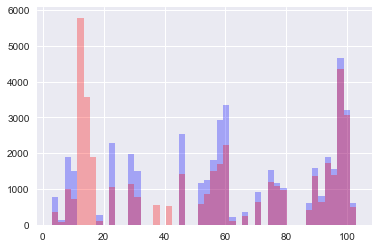

In [9]:
fig, ax = plt.subplots()
ax.hist(trips.start_station_id, bins = 48, fc = (0, 0, 1, 0.3))#niebieski
ax.hist(trips.end_station_id, bins = 48, fc = (1, 0, 0, 0.3))#czerwony

After seeing the above hist, I have decided to use 'end_station_id' for defining frequency of using stations

In [10]:
#finding patterns for type of member in using stations

In [11]:
trips_colnames

['trip_id',
 'subscriber_type',
 'bikeid',
 'start_time',
 'start_station_id',
 'start_station_name',
 'end_station_id',
 'end_station_name',
 'duration_minutes']

In [12]:
subscriber_types = trips['subscriber_type'].value_counts().to_frame()
subscriber_types = subscriber_types.reset_index().rename(columns = {'index':'old_name', 'subscriber_type':'frequency'})

# Types of subscription
On the website https://austin.bcycle.com/ there are 7 types of using bike:
- Pay-as-you-ride 
$1 to unlock then just $.23 per minute after that
    
- Local31 $11.00
Monthly Membership includes unlimited 60-minute trips. $4 per each additional 30 minutes. Auto-Renew Enabled. ONE TIME $15 (+tax) ACTIVATION FEE.

- Explorer $12.99
Unlimited 60 minute trips during a 24 hour time period. Usage fees of $4 (+tax) begin after 60 minutes. Bike must be returned to station to restart trip time.

- 3-Day Weekender $19.49
$18 + tax. 72-Hr Access Pass includes unlimited 60-min trips.

- Local365 $86.60
Annual Membership includes unlimited 60-minute trips. $4 per each additional 30 minutes. B-connected access to other B-cycle cities included.

- Student Membership $86.60
Must apply for verification on the students page to receive discounted rate. Available for UT @ Austin and HTU student. Same rules as Local365 apply.

After reviewing data I have also decided to add my own category as I see it was really popular, although don't know specific rules for it
- Walk up

In [13]:
subscriber_types.value_counts()

old_name                                          frequency
$1 Pay by Trip Fall Special                       41           1
Founding Member (Austin B-cycle)                  54           1
Local30                                           1755         1
Local30 ($11 plus tax)                            22           1
Local31                                           2181         1
Local365                                          9817         1
Local365 ($80 plus tax)                           166          1
Local365 Youth (age 13-17 riders)                 9            1
Local365 Youth with helmet (age 13-17 riders)     1            1
Local365+Guest Pass                               261          1
Local365+Guest Pass- 1/2 off Anniversary Special  15           1
Local365- 1/2 off Anniversary Special             110          1
Madtown Monthly                                   2            1
Membership: pay once  one-year commitment         1            1
Pay-as-you-ride               

In [14]:
annuals = subscriber_types[subscriber_types['old_name'].str.contains('Annual')].old_name
annuals_dict = dict(zip(annuals.to_list(),['Annual']*len(annuals)))

local365 = subscriber_types[subscriber_types['old_name'].str.contains('Local365')].old_name
local365_dict = dict(zip(local365.to_list(),['Annual']*len(local365)))

local31 = subscriber_types[subscriber_types['old_name'].str.contains('Local3'+'[0-1]')].old_name
local31_dict = dict(zip(local31.to_list(),['Local30']*len(local31)))

explorer = subscriber_types[subscriber_types['old_name'].str.contains('Explorer')].old_name
explorer_dict = dict(zip(explorer.to_list(),['Explorer']*len(explorer)))

weekender = subscriber_types[subscriber_types['old_name'].str.contains('Weekender')].old_name
weekender_dict = dict(zip(weekender.to_list(),['Weekender']*len(weekender)))

pay = subscriber_types[subscriber_types['old_name'].str.contains('Pay-as')].old_name
pay_dict = dict(zip(pay.to_list(),['Pay']*len(pay)))

student = subscriber_types[subscriber_types['old_name'].str.contains('Student')].old_name
student_dict = dict(zip(student.to_list(),['Student']*len(student)))

walk_up = subscriber_types[subscriber_types['old_name'].str.contains('Walk')].old_name
walk_up_dict = dict(zip(walk_up.to_list(),['Student']*len(walk_up)))

new_values_dict = annuals_dict|local365_dict|explorer_dict|weekender_dict|pay_dict|student_dict|walk_up_dict

other = subscriber_types[~subscriber_types['old_name'].isin(list(new_values_dict.keys()))].old_name
other_dict = dict(zip(other.to_list(),['Other']*len(other)))

new_values_dict = new_values_dict|other_dict

In [15]:
trips = trips.replace({'subscriber_type':new_values_dict})

In [23]:
annual_trips = trips[trips.subscriber_type == 'Annual']
not_annual_trips = trips[trips.subscriber_type != 'Annual']

In [27]:
time_for_hist = [_ for i in range(0,10,10)]

In [34]:
trips.duration_minutes.describe()

count    43597.000000
mean        42.712457
std        183.146741
min          0.000000
25%          8.000000
50%         18.000000
75%         44.000000
max      18910.000000
Name: duration_minutes, dtype: float64

# Columns for drawing data on maps
I have decided to add normalized frequency for using in in rgb palette while drawing to map
Grey color is for (almost) unused stations
As the hue of blue color is getting darker, it means the station has more interest

In [17]:
annual_fav_stations = trips['end_station_id'][trips['subscriber_type'] == 'Annual'].value_counts().to_frame()
annual_fav_stations = annual_fav_stations.reset_index().rename(columns = {'index':'station_id','end_station_id':'frequency'})
annual_fav_stations['normalized_freq'] = (annual_fav_stations['frequency']-annual_fav_stations['frequency'].min())/(annual_fav_stations['frequency'].max()-annual_fav_stations['frequency'].min())
annual_fav_stations = pd.merge(annual_fav_stations,stations[['station_id','longitude','latitude']], how = 'left')


In [18]:
not_annual_fav_stations = trips['end_station_id'][trips['subscriber_type'] != 'Annual'].value_counts().to_frame()
not_annual_fav_stations = not_annual_fav_stations.reset_index().rename(columns = {'index':'station_id','end_station_id':'frequency'})
not_annual_fav_stations['normalized_freq'] = (not_annual_fav_stations['frequency']-not_annual_fav_stations['frequency'].min())/(not_annual_fav_stations['frequency'].max()-not_annual_fav_stations['frequency'].min())
not_annual_fav_stations = pd.merge(not_annual_fav_stations,stations[['station_id','longitude','latitude']], how = 'left')


In [19]:
draw_map(annual_fav_stations)

Map(center=[30.2672, -97.7431], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [102]:
draw_map(not_annual_fav_stations)

Map(center=[30.2672, -97.7431], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…